In [36]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import Convex as cvx 
import MeshCat as mc 
using Test
using Random
import Convex as cvx 
import ForwardDiff as FD
import ECOS      
include(joinpath(@__DIR__,"ref_traj.jl"))
include(joinpath(@__DIR__,"planar_hexrotor_dynamics.jl"))

  Activating environment at `c:\Users\scott\Documents\OCRL\MPCwZAC\Project.toml`


animate_hexrotor (generic function with 1 method)

In [37]:
function linearize(model, state_eq, input_eq, dt)
    

    n_states = length(state_eq)
    n_inputs = length(input_eq)
    
    A = zeros(n_states, n_states)
    B = zeros(n_states, n_inputs)
    
    epsilon = 1e-6
    
    for i in 1:n_states
        delta = zeros(n_states)
        delta[i] = epsilon
        state_plus = state_eq + delta
        state_minus = state_eq - delta
        
        f_plus = hexrotor_dynamics(state_plus, input_eq)
        f_minus = hexrotor_dynamics(state_minus, input_eq)
        
        A[:, i] = (f_plus - f_minus) / (2 * epsilon)
    end
    
    for i in 1:n_inputs
        delta = zeros(n_inputs)
        delta[i] = epsilon
        input_plus = input_eq + delta
        input_minus = input_eq - delta
        
        f_plus = hexrotor_dynamics(state_eq, input_plus)
        f_minus = hexrotor_dynamics(state_eq, input_minus)
        
        B[:, i] = (f_plus - f_minus) / (2 * epsilon)
    end
    
    return A, B
end

function kalman_filter(A, B, C, D, Q, R, x_hat, P, u, y, W, w)
    # w is the wind input 
    # W is the system response to wind 
    x_hat_minus = A * x_hat + B * u + W * w
    P_minus = A * P * A' + Q
    
    K = P_minus * C' / (C * P_minus * C' + R)
    x_hat_plus = x_hat_minus + K * (y - C * x_hat_minus - D * u)
    P_plus = (I - K * C) * P_minus
    
    return x_hat_plus, P_plus
end

function update_wind(current_wind, dt, intensity)
    # Random walk update
    d_wind = randn(size(current_wind)) .* sqrt(intensity * dt)
    new_wind = current_wind + d_wind
    return new_wind
end



update_wind (generic function with 1 method)

In [38]:
"""
`u = convex_mpc(A,B,X_ref_window,xic,xg,u_min,u_max,N_mpc)`

setup and solve the above optimization problem, returning the 
first control u_1 from the solution (should be a length nu 
Vector{Float64}).  
"""
function convex_mpc(A::Matrix, # discrete dynamics matrix A
                    B::Matrix, # discrete dynamics matrix B
                    X_ref_window::Vector{Vector{Float64}}, # reference trajectory for this window 
                    xic::Vector, # current state x 
                    u_min::Vector, # lower bound on u 
                    u_max::Vector, # upper bound on u 
                    N_mpc::Int64,  # length of MPC window (horizon)
                    wind_dynamics::Matrix, # discrete dynamics of wind W
                    wind_velocity::Vector # current wind state w
                    )::Vector{Float64} # return the first control command of the solved policy 
    
    # get our sizes for state and control
    nx,nu = size(B)
    
    # check sizes 
    @assert size(A) == (nx, nx)
    @assert length(xic) == nx 
    @assert length(X_ref_window) == N_mpc 
        
    # LQR cost
    Q = diagm(ones(nx))
    R = diagm(ones(nu))

    # variables we are solving for
    X = cvx.Variable(nx,N_mpc)
    U = cvx.Variable(nu,N_mpc-1)

    obj = 0 

    for i = 1:N_mpc-1
        obj += (0.5*cvx.quadform(X[:,i]-X_ref_window[i], Q)+0.5*cvx.quadform(U[:,i], R))
    end
    obj += 0.5*cvx.quadform(X[:,N_mpc]-X_ref_window[N_mpc], Q)

    # create problem with objective
    prob = cvx.minimize(obj)

    prob.constraints += (X[:,1] == xic)
    for i = 1:N_mpc-1
        prob.constraints += (X[:,i+1] == A*X[:,i] + B*U[:,i] + wind_dynamics * wind_velocity)
        prob.constraints += (u_min ≤ U[:,i])
        prob.constraints += (U[:,i] ≤ u_max)
    end
    

    # solve problem 
    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)

    # get X and U solutions 
    X = X.value
    U = U.value
    
    # return first control U 
    return U[:,1]
end

convex_mpc

In [45]:
# Drone parameters
Ixx= 2.331e2
Iyy= 2.322e2
Izz= 4.022e2
model = (mass= 6.728,
    J= Diagonal([Ixx, Iyy, Izz]), 
    gravity= [0,0,-9.81],
    L= 1.075, 
    kf= 0.1, # constant thrust coefficient 
    km= 0.01, # propeller drag coefficient
    dt= 0.01, # 100 Hz
    α= 0 * (π / 180), # optimal value determined from paper
    β= 0 * (π / 180), # optimal value determined from paper
    λ= (((π/3))) # each propeller is 60 degrees from each other TODO fix this (?)
)
# Simulation parameters
dt = 0.01
N = 1000
time = 1:N
n_states = 12
n_inputs = 6

# MPC Parameters
Q = I * 10
R = I * 0.000001
N_mpc = 20
u_min = zeros(n_inputs)
u_max = 1000000*ones(n_inputs)

# Initialize wind parameters
wind_dynamics = zeros(n_states, 3)
wind_dynamics[4, 1] = 1  # Wind effect on vx
wind_dynamics[5, 2] = 1  # Wind effect on vy
wind_dynamics[6, 3] = 1  # Wind effect on vz
wind_velocity = [0.5, 0, 0] # Intensity of the turbulence
wind_intensity = 0.5

# Generate hover trajectory for hexrotor
X_ref, U_ref = create_ref_hover(model, N+N_mpc, dt, n_inputs)
# U_ref isn't used by the controller at all

# check dimensions
@assert length(X_ref[1]) == n_states
@assert length(U_ref[1]) == n_inputs

true_states = []
estimated_states = []
inputs = []

# initialize sim variables
P = I(n_states)
true_state = X_ref[1]
x_hat = true_state
u_mpc = U_ref[1]
measurements = true_state


# Linearize system
#A, B = linearize(X_ref[1], U_ref[1], dt)
A = FD.jacobian(dx -> rk4(model, hexrotor_dynamics, dx, U_ref[1], dt), X_ref[1])
B = FD.jacobian(du -> rk4(model, hexrotor_dynamics, X_ref[1], du, dt), U_ref[1])
C = I(n_states)
D = zeros(n_states, n_inputs)

# Update simulation loop to include wind update
for i in time
    # Update wind with turbulence model
    wind_velocity = update_wind(wind_velocity, dt, wind_intensity)
    # Linearize system
    # A, B = linearize(X_ref[1], U_ref[1], dt)
    A = FD.jacobian(dx -> rk4(model, hexrotor_dynamics, dx, U_ref[1], dt), true_state)
    B = FD.jacobian(du -> rk4(model, hexrotor_dynamics, true_state, du, dt), U_ref[1])

    # Run KF
    x_hat, P = kalman_filter(A, B, C, D, Q, R, x_hat, P, u_mpc, measurements, wind_dynamics, wind_velocity)
    
    push!(estimated_states, x_hat)

    # TODO: given a window of N_mpc timesteps, get current reference trajectory
    X_ref_tilde = X_ref[i:i+N_mpc-1]
    
    # TODO: call convex mpc controller with state estimate 
    u_mpc = convex_mpc(A, B, X_ref_tilde, x_hat, u_min, u_max, N_mpc, wind_dynamics, wind_velocity)
    #u_mpc = u_mpc + U_ref[1]
    # u_mpc = [6000, 0, 0, 0, 0, 0]
    push!(inputs, u_mpc)

    true_state = rk4(model, hexrotor_dynamics, true_state, u_mpc, dt)
    # true_state = A*true_state + B*u_mpc
    push!(true_states, true_state)

    measurements = true_state + randn(n_states) * 0.001
end



┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


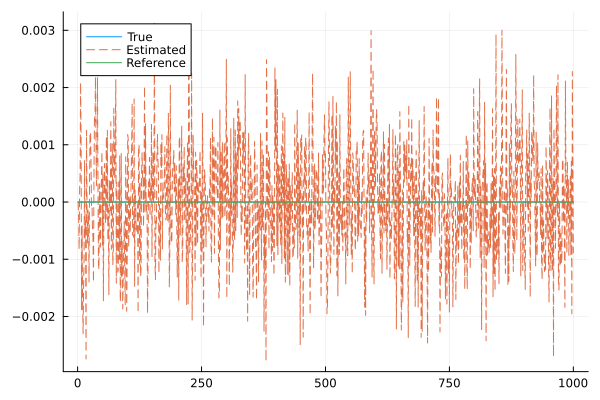

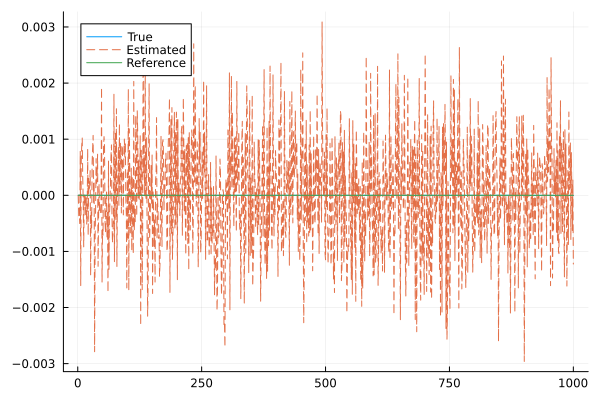

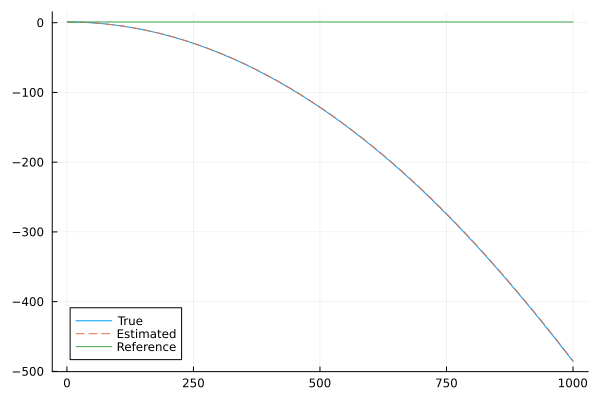

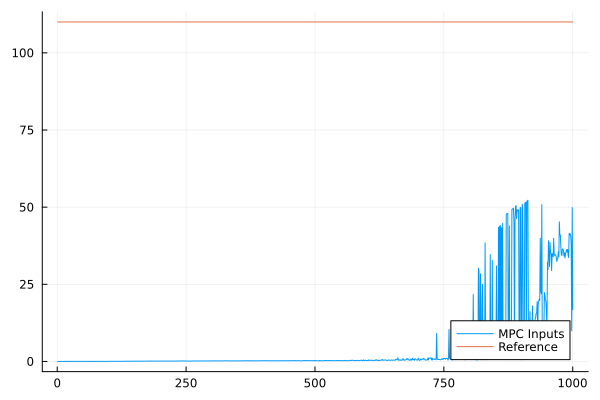

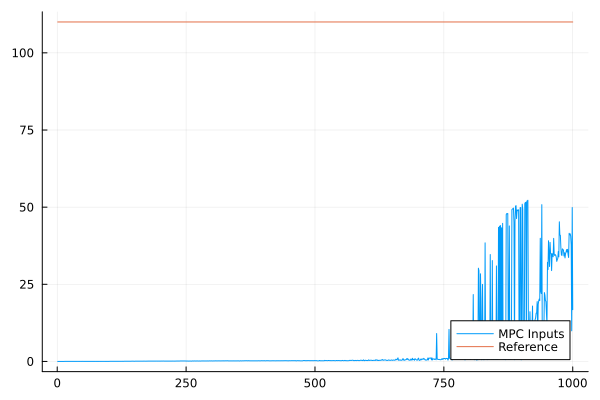

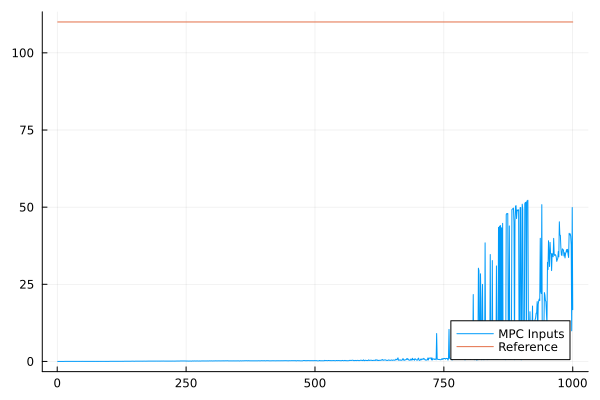

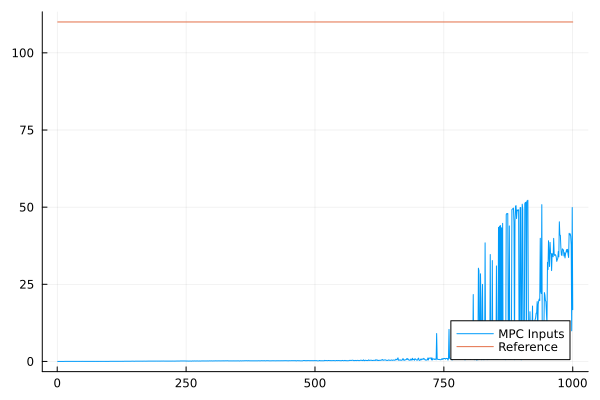

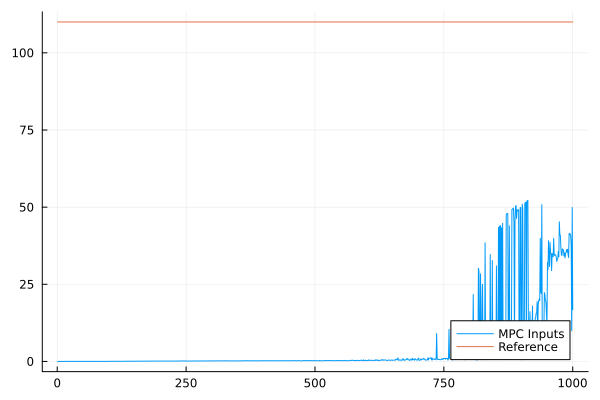

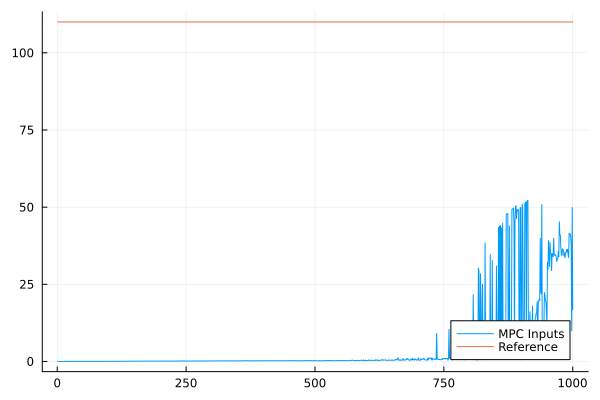

In [47]:

# Convert results to arrays for plotting
true_states_plot = hcat(true_states...)
estimated_states_plot = hcat(estimated_states...)
U_ref_plot = hcat(U_ref...)
X_ref_plot = hcat(X_ref...)
inputs_plot = hcat(inputs...)


# Plotting
for i in 1:3
    p = plot(time, true_states_plot[i, :], label="True")
    plot!(time, estimated_states_plot[i, :], label="Estimated", linestyle=:dash)
    plot!(time, X_ref_plot[i, 1:N], label = "Reference")
    display(p)
end
for i in 1:n_inputs
    p = plot(time, inputs_plot[i, :], label="MPC Inputs")
    plot!(time, U_ref_plot[i, 1:N], label = "Reference")
    display(p)
end

In [18]:
print(inputs_plot[1,:])

[0.0003275375775118441, 0.00045302928158685857, 0.00015208756117028835, 0.0002379614500703347, 0.0005038566097300976, 0.0005449162114406311, 0.0004691257866747986, 0.00014274169187457962, 0.0007106486751222391, 0.00014434052791951593, 0.00029476627361978586, 0.0001381340426220404, 0.0003084341095477376, 0.0003066653894886335, 0.00015964334279719113, 0.00010811609912619662, 0.000938707556252093, 0.000510579823001811, 0.00024107993819336244, 0.000601029317255437, 0.0008706540602509076, 0.0002237022000039581, 0.00010540369377645014, 0.000251113828295265, 0.0005063714767536727, 0.0008991184960771277, 0.0005488931786000866, 0.0002873128143923745, 0.00017431872511239314, 0.0002123197469457838, 0.00035848419301881117, 0.00034850174940292045, 0.0004241687113058901, 0.0003489937683759522, 0.0005135219997936128, 0.0002341098921537704, 0.0006425312409763761, 0.0009031113450195579, 0.00041139998188264486, 0.0003708595938285171, 0.0004014325230517903, 0.0008050705068750993, 0.00033248667308408364, 